In [ ]:
import pandas as pd
import numpy as np
import zipfile

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/NSL-KDD.zip', 'r') as zip_ref: # Распаковка набора данных
  zip_ref.extractall('/content')

In [ ]:
head = ["duration","protocol_type","service","flag","src_bytes",  # Определение заголовка
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "diff"]

In [ ]:
data_train = pd.read_csv('/content/KDDTrain+.txt', names=head) # Считывание набора данных
data_test = pd.read_csv('/content/KDDTest+.txt', names=head)

In [ ]:
data = pd.concat([data_train, data_test], ignore_index=True)  #Объединение тестового и обучающего набора данных
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,diff
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,tcp,smtp,SF,794,333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,100,141,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148513,0,tcp,http,SF,317,938,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,11,0.0,0.0,0.0,0.0,1.00,0.00,0.18,197,255,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,normal,21
148514,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,5,10,0.0,0.0,0.0,0.0,1.00,0.00,0.20,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,back,15
148515,0,udp,domain_u,SF,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0.0,0.0,0.0,0.0,1.00,0.00,0.33,255,252,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
data.info() # Проверка на отсутствие данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13 

Для корректного обучения модели нужно сбалансировать набор данных. Для этого возьмём примерно одинаковое количество разных типов атак и нормальных данных.

In [ ]:
data.label.value_counts() # Подсчет количества атак разного типа

normal             77054
neptune            45871
satan               4368
ipsweep             3740
smurf               3311
portsweep           3088
nmap                1566
back                1315
guess_passwd        1284
mscan                996
warezmaster          964
teardrop             904
warezclient          890
apache2              737
processtable         685
snmpguess            331
saint                319
mailbomb             293
pod                  242
snmpgetattack        178
httptunnel           133
buffer_overflow       50
land                  25
multihop              25
rootkit               23
named                 17
ps                    15
sendmail              14
xterm                 13
imap                  12
ftp_write             11
loadmodule            11
xlock                  9
phf                    6
perl                   5
xsnoop                 4
spy                    2
sqlattack              2
worm                   2
udpstorm               2


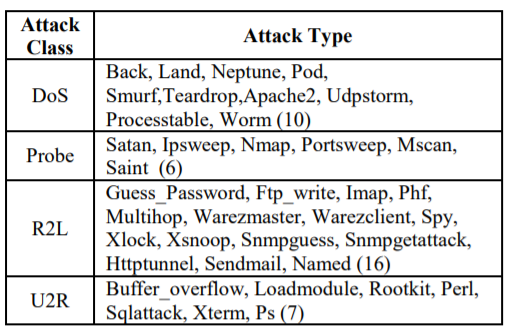

Возьмём следующие типы данных:
1.   DoS - neptune
2.   Probe - satan
3.   R2L - guess_passwd
4.   Normal

In [ ]:
norm_data = pd.DataFrame()  # Распределение данных

norm_data = pd.concat([data[data['label']=='normal'][0:1300],
                      data[data['label']=='neptune'][0:1300],
                       data[data['label']=='satan'][0:1300],
                       data[data['label']=='guess_passwd']], ignore_index = True)
norm_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,diff
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
4,0,tcp,http,SF,287,2251,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,7,0.0,0.0,0.0,0.0,1.00,0.00,0.43,8,219,1.00,0.00,0.12,0.03,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5179,4,tcp,pop_3,SF,28,93,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,55,53,0.95,0.04,0.02,0.04,0.00,0.00,0.00,0.00,guess_passwd,6
5180,0,tcp,telnet,SF,122,174,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,62,0.24,0.02,0.00,0.00,0.00,0.00,0.01,0.05,guess_passwd,11
5181,0,tcp,pop_3,SF,30,217,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,10,0.04,0.03,0.00,0.00,0.01,0.00,0.00,0.00,guess_passwd,5
5182,4,tcp,pop_3,SF,28,93,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,179,0.70,0.02,0.00,0.00,0.00,0.00,0.11,0.00,guess_passwd,15


После того, как мы отобрали необходимые данные, их нужно обработать. Все текстовые представления приводим к числовому виду, стандартизируем все значения. Также нужно провести анализ значимости особенностей и удалить ненужные.

In [ ]:
# функции для приведения к числовому виду
def encode(df):
  encoder = LabelEncoder()
  target = encoder.fit_transform(df)
  return np.array(target)

def df_norm(data):
  cols = list(data.columns[1:4])
  res_col = data.columns[-2]
  for col in cols:
    data[f'num_{col}'] = encode(data[col])
  data[f'num_{res_col}'] = encode(data[res_col])

  return data

In [ ]:
df_norm(norm_data)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,diff
0,0,1,20,7,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,2,20
1,0,2,43,7,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,2,15
2,0,1,23,7,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,2,21
3,0,1,23,7,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,21
4,0,1,23,7,287,2251,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,7,0.0,0.0,0.0,0.0,1.00,0.00,0.43,8,219,1.00,0.00,0.12,0.03,0.00,0.00,0.00,0.00,2,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5179,4,1,46,7,28,93,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,55,53,0.95,0.04,0.02,0.04,0.00,0.00,0.00,0.00,0,6
5180,0,1,59,7,122,174,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,62,0.24,0.02,0.00,0.00,0.00,0.00,0.01,0.05,0,11
5181,0,1,46,7,30,217,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,10,0.04,0.03,0.00,0.00,0.01,0.00,0.00,0.00,0,5
5182,4,1,46,7,28,93,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,179,0.70,0.02,0.00,0.00,0.00,0.00,0.11,0.00,0,15


Выводим корреляции.

In [ ]:
norm_data.corr()['num_label'][abs(norm_data.corr()['num_label'])<0.05]

duration                       0.028515
src_bytes                      0.017945
dst_bytes                      0.043926
hot                            0.002416
num_compromised                0.013239
root_shell                     0.008715
su_attempted                   0.008715
num_root                       0.016169
num_file_creations             0.011156
num_access_files               0.019503
dst_host_count                 0.015459
dst_host_srv_diff_host_rate    0.013068
Name: num_label, dtype: float64

Удаляем ненужные колонки.

In [ ]:
norm_data = norm_data.drop(['flag', 'service', 'protocol_type', 'hot', 'su_attempted', 'root_shell'], axis=1)

In [ ]:
norm_data.to_csv('/content/final_train_data.csv', index=False)